In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, mean_absolute_percentage_error

from catboost import CatBoostClassifier, CatBoostRegressor
from IPython.display import clear_output

import sys
sys.path.append("..")

from src.mofa_utils import train_mofa
from src.tcga_preprocess_utils import split_patients_for_survival_prediction
from src.constants import RANDOM_STATE

In [2]:
survival_data_breast = pd.read_csv('data/breast/survival_data_breast.csv')
mofa_data_breast = pd.read_csv('data/breast/mofa_data_breast.csv')
clinical_data_breast = pd.read_csv('data/breast/clinical_data_breast.csv')

assert (survival_data_breast['PatientID'] == mofa_data_breast['sample'].drop_duplicates()).all()
assert (clinical_data_breast['sampleID'] == mofa_data_breast['sample'].drop_duplicates()).all()

In [3]:
train_indexes, test_indexes = split_patients_for_survival_prediction(survival_data_breast)

In [6]:
N_FACTORS = 20
TARGET_RELATED_CLINICAL_COLS = ['Days_to_Date_of_Last_Contact_nature2012', 'Days_to_date_of_Death_nature2012']
CATEGORICAL_CLINICAL_FEATURES = ['AJCC_Stage_nature2012', 'Converted_Stage_nature2012', 'ER_Status_nature2012', 'Gender_nature2012', 'HER2_Final_Status_nature2012', 'Metastasis_nature2012', 'Node_nature2012', 'Tumor_nature2012']
NUMERICAL_CLINICAL_FEATURES = ['Age_at_Initial_Pathologic_Diagnosis_nature2012']

In [23]:
clinical_features = clinical_data_breast[NUMERICAL_CLINICAL_FEATURES + CATEGORICAL_CLINICAL_FEATURES]

for col in clinical_features.columns[1:]:
    clinical_features[col] = clinical_features[col].fillna('missing')

clinical_features

,Age_at_Initial_Pathologic_Diagnosis_nature2012,AJCC_Stage_nature2012,Converted_Stage_nature2012,ER_Status_nature2012,Gender_nature2012,HER2_Final_Status_nature2012,Metastasis_nature2012,Node_nature2012,Tumor_nature2012
0,NaN,missing,missing,missing,missing,missing,missing,missing,missing
1,NaN,missing,missing,missing,missing,missing,missing,missing,missing
2,NaN,missing,missing,missing,missing,missing,missing,missing,missing
3,NaN,missing,missing,missing,missing,missing,missing,missing,missing
4,NaN,missing,missing,missing,missing,missing,missing,missing,missing
...,...,...,...,...,...,...,...,...,...
615,NaN,missing,missing,missing,missing,missing,missing,missing,missing
616,NaN,missing,missing,missing,missing,missing,missing,missing,missing
617,NaN,missing,missing,missing,missing,missing,missing,missing,missing
618,NaN,missing,missing,missing,missing,missing,missing,missing,missing


### MOFA

Обучаем модель

In [9]:
factors, weights, r2 = train_mofa(mofa_data_breast.copy(), RANDOM_STATE, factors=N_FACTORS)
clear_output()

Классификация: предсказание смерти

In [24]:
np_df = pd.DataFrame(factors)
combined_df = pd.concat([np_df, clinical_features], axis=1)
cat_features_indices = list(range(N_FACTORS + 1, combined_df.shape[1]))

In [25]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Death'][train_indexes], survival_data_breast['Death'][test_indexes]

In [26]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

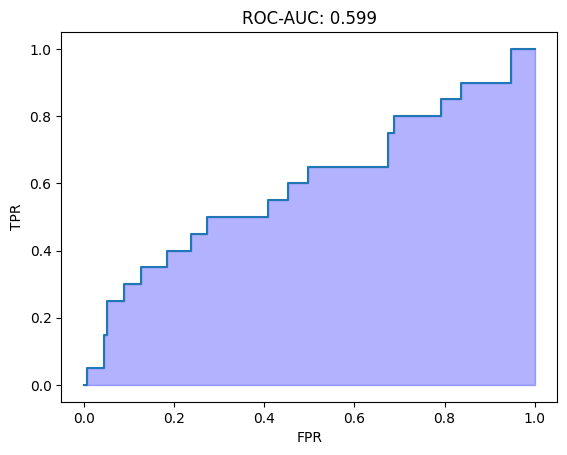

In [27]:
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

fpr, tpr, thresholds = roc_curve(y_test.values, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {np.round(roc_auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.fill_between(fpr, tpr, color= "b", alpha=0.3);

Регрессия: предсказание survival

In [30]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Survival'][train_indexes], survival_data_breast['Survival'][test_indexes]

In [31]:
cb_regressor = CatBoostRegressor(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_regressor.fit(X_train, y_train)

y_pred = cb_regressor.predict(X_test)

In [32]:
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) * 100)

MAPE:  124.45348891535713


### RGCCA

In [34]:
dna_breast = pd.read_csv('data/breast/expression_data_breast.csv', index_col=[0]).fillna(0.)
rna_breast = pd.read_csv('data/breast/mirna_data_breast.csv', index_col=[0]).fillna(0.)
methylation_breast = pd.read_csv('data/breast/methylation_data_breast.csv', index_col=[0]).fillna(0.)


In [35]:
from mvlearn.embed import MCCA

X_breast = [dna_breast.values, rna_breast.values, methylation_breast.values]
cca = MCCA(n_components=N_FACTORS, regs='oas', multiview_output=False)

X_breast_cca = cca.fit_transform(X_breast)

In [36]:
np_df = pd.DataFrame(X_breast_cca)
combined_df = pd.concat([np_df, clinical_features], axis=1)
cat_features_indices = list(range(N_FACTORS + 1, combined_df.shape[1]))

In [38]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Death'][train_indexes], survival_data_breast['Death'][test_indexes]

In [39]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

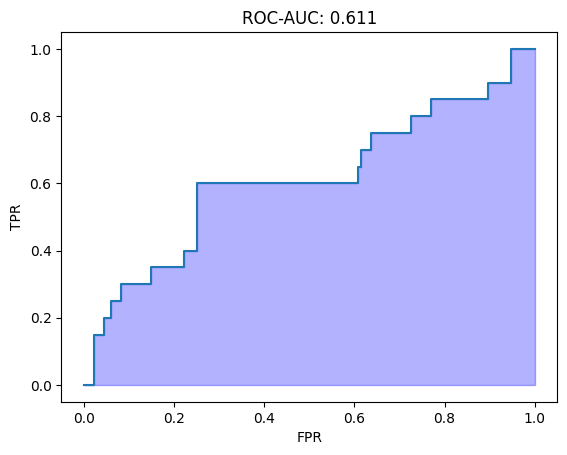

In [40]:
roc_auc = roc_auc_score(y_test, y_probas[:, 1])
fpr, tpr, thresholds = roc_curve(y_test.values, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {np.round(roc_auc, 3)}')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.fill_between(fpr, tpr, color= "b", alpha=0.3);

In [41]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Survival'][train_indexes], survival_data_breast['Survival'][test_indexes]

In [42]:
cb_regressor = CatBoostRegressor(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_regressor.fit(X_train, y_train)

y_pred = cb_regressor.predict(X_test)

In [43]:
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) * 100)

MAPE:  111.00339177490031


### PCA

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components=N_FACTORS)

expr_low = pca.fit_transform(dna_breast.values)
rna_low = pca.fit_transform(rna_breast.values)
methyl_low = pca.fit_transform(methylation_breast.values)

X_breast_low = np.hstack([expr_low, rna_low, methyl_low])

In [47]:
np_df = pd.DataFrame(X_breast_low)
combined_df = pd.concat([np_df, clinical_features], axis=1)
cat_features_indices = list(range(N_FACTORS * 3 + 1, combined_df.shape[1]))

In [50]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Survival'][train_indexes], survival_data_breast['Survival'][test_indexes]

In [52]:
cb_regressor = CatBoostRegressor(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_regressor.fit(X_train, y_train)

y_pred = cb_regressor.predict(X_test)

In [53]:
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) * 100)

MAPE:  122.93664279715858


### Без факторизации

In [55]:
expr = dna_breast.values
rna = rna_breast.values
methyl = methylation_breast.values

X_breast_all = np.hstack([expr, rna, methyl])

In [60]:
np_df = pd.DataFrame(X_breast_all)
combined_df = pd.concat([np_df, clinical_features], axis=1)
cat_features_indices = list(range(X_breast_all.shape[1] + 1, combined_df.shape[1]))

In [64]:
X_train, X_test, y_train, y_test = combined_df.values[train_indexes], combined_df.values[test_indexes], survival_data_breast[
    'Survival'][train_indexes], survival_data_breast['Survival'][test_indexes]

In [65]:
cb_regressor = CatBoostRegressor(n_estimators=5000, random_state=RANDOM_STATE, silent=True, cat_features=cat_features_indices)
cb_regressor.fit(X_train, y_train)

y_pred = cb_regressor.predict(X_test)

In [66]:
print('MAPE: ', mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred) * 100)

MAPE:  119.44806649387083
